# Realizing Controllers using Analog Circuits

In [39]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

try:
    import lcapy
except ModuleNotFoundError:
    print("Could not find lcapy - installing")
    !sudo apt install texlive-latex-recommended # takes about 30 sec
    !sudo apt-get install texlive-latex-extra --no-install-recommends # 10 sec
    !sudo apt install imagemagick # 10 sec
    !pip install sympy==1.10.1
    !pip install lcapy # takes 5 sec
    !pip install pdflatex # takes about 5 sec
    print("Will need to restart the Kernel")

from lcapy import Circuit, j, omega, s, exp
from lcapy import R, C, L, symbol

from sympy import N
from control.matlab import tf

from control_materials import *

# make sure the data is available to plot
data_file = ["data/Analog_Lag_lead.csv", "data/Active_Resonant.csv",\
             "data/Active_Lag_lead.csv","data/Analog_Lag_lead2.csv"]
if not np.min([os.path.isfile(data_file[x]) for x in np.arange(len(data_file))]):
    for dfile in data_file:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

R1 = 10e3
C1 = 10e-6

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


# Analog Circuits to build Lead and Lag Functionality 

In [40]:
CC = 0.1e-6 # capacitor value
RR = 100e3 # res value
Rs1 = RR
Rs2 = 0.1*RR
zero = 1/Rs1/CC
print(f"{zero/2/np.pi = :8.3f} Hz")
RT = Rs1*Rs2/(Rs1+Rs2)
pole = 1/RT/CC
print(f"{pole/2/np.pi = :8.3f} Hz")

zero/2/np.pi =   15.915 Hz
pole/2/np.pi =  175.070 Hz


# Lead 

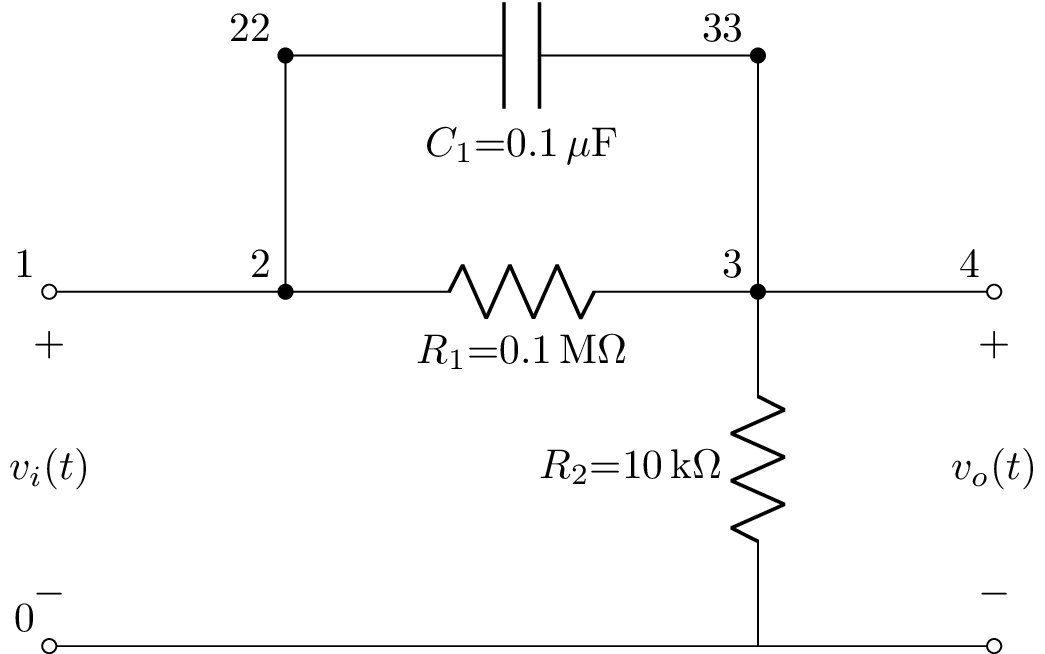

In [41]:
cct_lead = Circuit("""
P1 1 0 ; down=1.5, v_=v_i(t)
W1 1 2; right=1
R1 2 3 R; right=2
W22 2 22; up=1
C1 22 33 C; right=2
W33 33 3; down=1
R2 3 0_3 0.1*R; down=1.5
W03 0 0_3; right=1.5
W3 3 4; right=1
W04 0_3 0_4; right=1
P2 4 0_4; down, v^=v_o(t)
""")
cct8 = cct_lead.subs({'R': RR, 'C':CC})
cct8.draw()

In [42]:
cct_lead.P1.transfer('P2')

     1   
s + ───  
    C⋅R  
───────⋅1
    11   
s + ───  
    C⋅R  

In [43]:
fv = logspace(0, 4, 1000)
w = fv *2*np.pi

Hl = cct8.P1.transfer('P2').limit('A', oo)
Num,Den = N(Hl).as_N_D()
NN = [Num.coeffs()[x].fval for x in range(len(Num.coeffs()))]
DD = [Den.coeffs()[x].fval for x in range(len(Den.coeffs()))]

G = tf(np.real(NN),np.real(DD))
print("Poles = "+', '.join('{:6.2f}'.format(x) for x in G.poles()/2/np.pi))
print("Zeros = "+', '.join('{:6.2f}'.format(x) for x in G.zeros()/2/np.pi))


Poles = -175.07+0.00j
Zeros = -15.92+0.00j


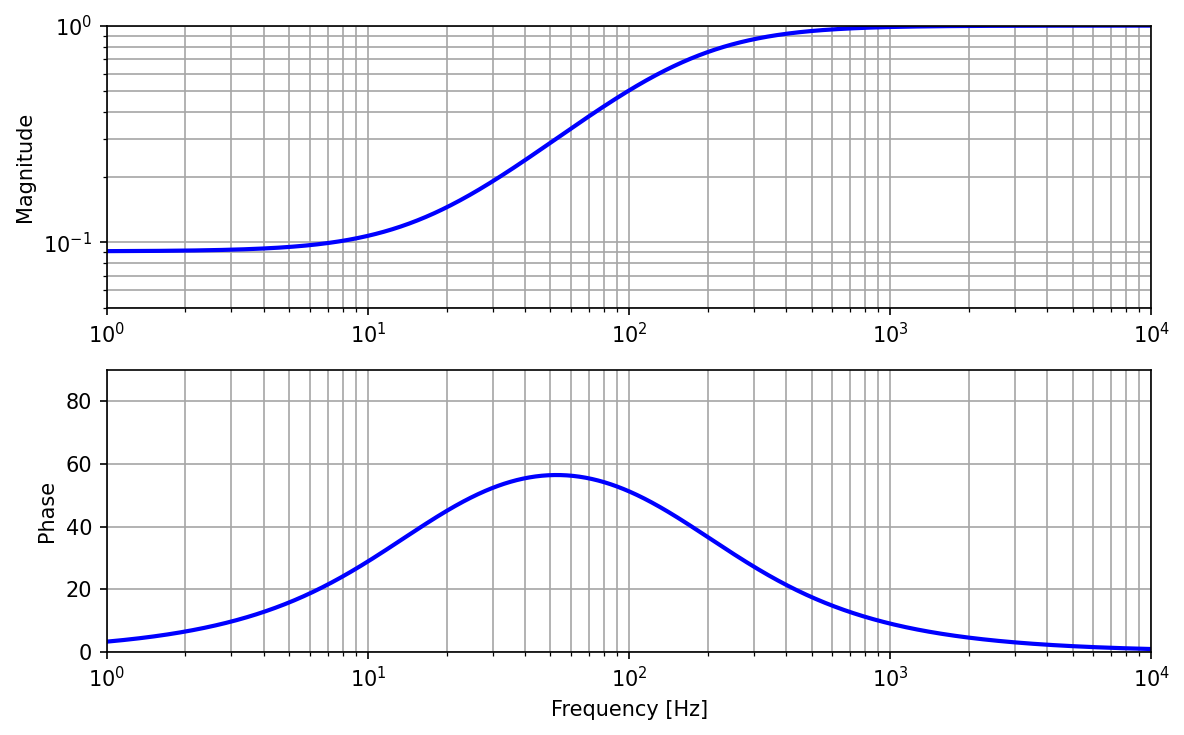

In [44]:
Gf = G(complex(0,1)*w)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-')
ax[1].semilogx(fv,np.angle(Gf)*r2d,color='b',ls='-')
ax[0].set_ylim([.05,1])
ax[1].set_ylim([0,90])
#ax[0].set_xlim([.1,10])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
savefig('figs/Analog_Lead.pdf',dpi=600)

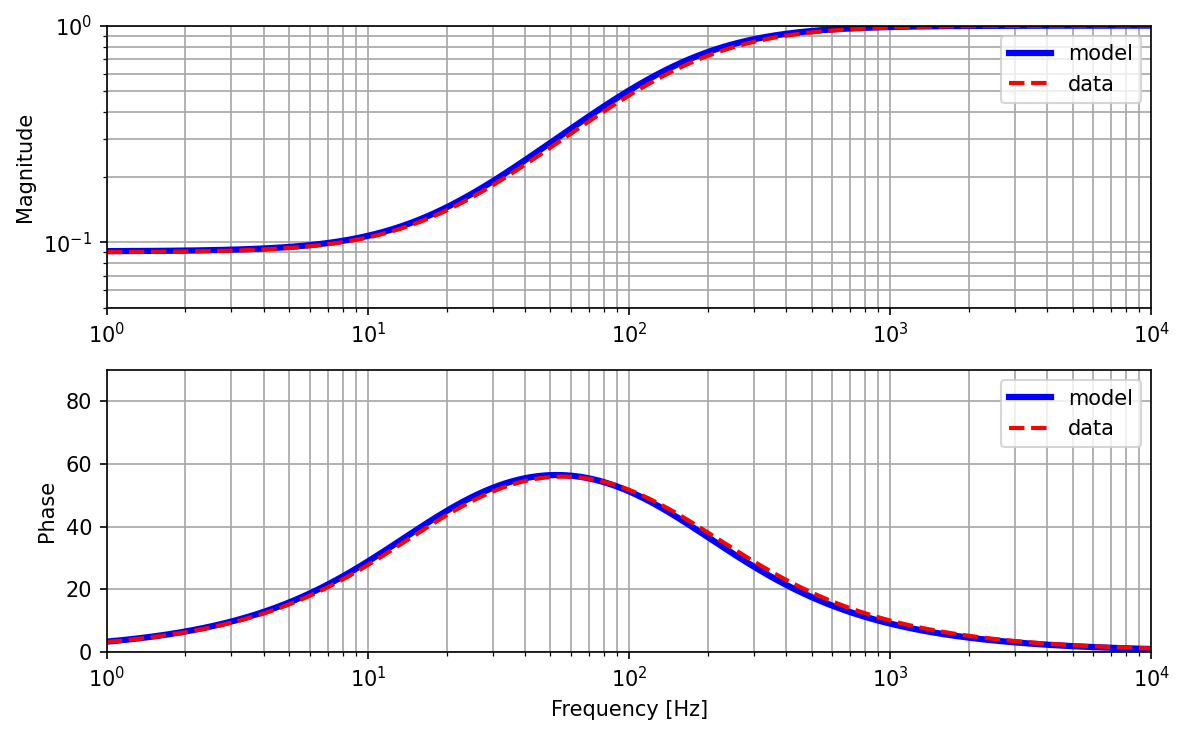

In [45]:
#Data
data = np.genfromtxt('data/Analog_Lag_lead.csv', delimiter=",")

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-',lw=3,label='model')
ax[0].loglog(data[:,0],data[:,1],color='r',ls='--',label='data')
ax[1].semilogx(fv,np.angle(Gf)*r2d,color='b',ls='-',lw=3,label='model')
ax[1].semilogx(data[:,0],data[:,2],color='r',ls='--',label='data')
ax[0].set_ylim([.05,1])
ax[1].set_ylim([0,90])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
ax[0].legend()
ax[1].legend()
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
savefig('figs/Analog_Lead_with_data.pdf',dpi=600)

# Lag Lead

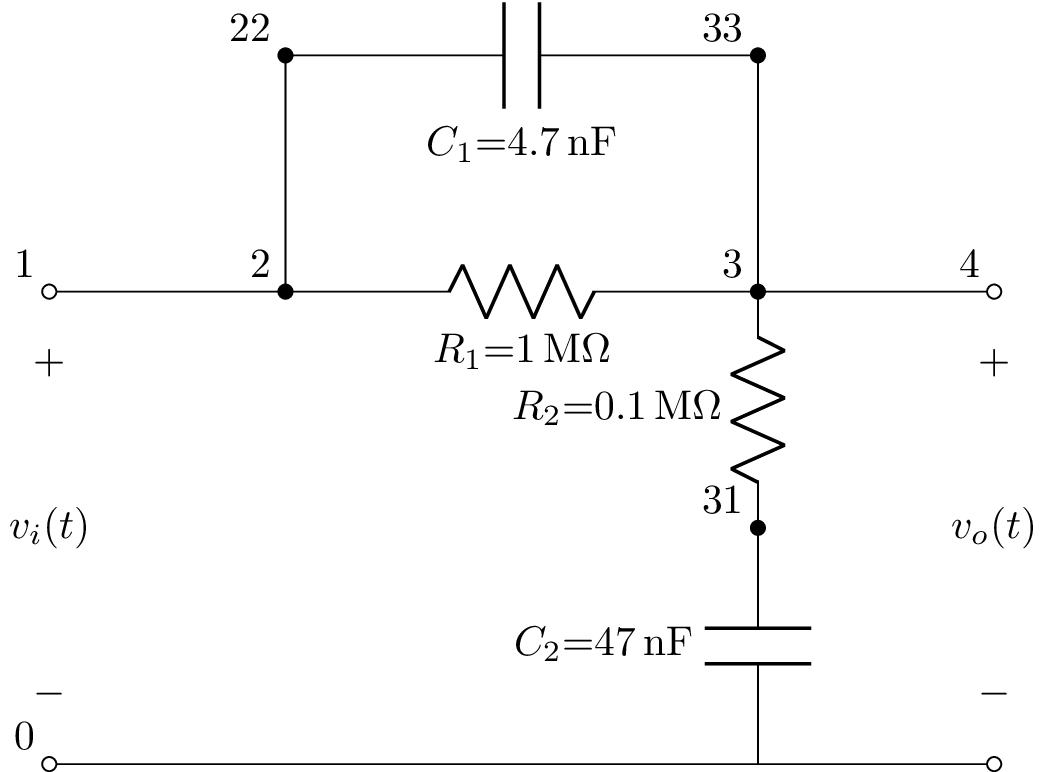

In [46]:
cct_lead = Circuit("""
P1 1 0 ; down=1.5, v_=v_i(t)
W1 1 2; right=1
R1 2 3 10*R; right=2
W22 2 22; up=1
C1 22 33 .047*C; right=2
W33 33 3; down=1
R2 3 31 R; down=1
C2 31 0_3 .47*C; down=1
W03 0 0_3; right=1.5
W3 3 4; right=1
W04 0_3 0_4; right=1
P2 4 0_4; down, v^=v_o(t)
""")
cct8 = cct_lead.subs({'R': RR, 'C':CC, 'C2':CC})
cct8.draw()

In [47]:
cct_lead.P1.transfer('P2')

 2   200⋅s      10000     
s  + ────── + ──────────  
     47⋅C⋅R         2  2  
              2209⋅C ⋅R   
────────────────────────⋅1
 2   1200⋅s     10000     
s  + ────── + ──────────  
     47⋅C⋅R         2  2  
              2209⋅C ⋅R   

In [48]:
Hl = cct8.P1.transfer('P2').limit('A', oo)
Num,Den = N(Hl).as_N_D()
NN = [Num.coeffs()[x].fval for x in range(len(Num.coeffs()))]
DD = [Den.coeffs()[x].fval for x in range(len(Den.coeffs()))]

G = tf(np.real(NN),np.real(DD))
print("Poles = "+', '.join('{:6.2f}'.format(x) for x in G.poles()/2/np.pi))
print("Zeros = "+', '.join('{:6.2f}'.format(x) for x in G.zeros()/2/np.pi))
G

Poles = -403.51+0.00j, -2.84+0.00j
Zeros = -33.86+0.00j, -33.86+0.00j


TransferFunction(array([   0.000,    0.009,    1.000]), array([   0.000,    0.056,    1.000]))

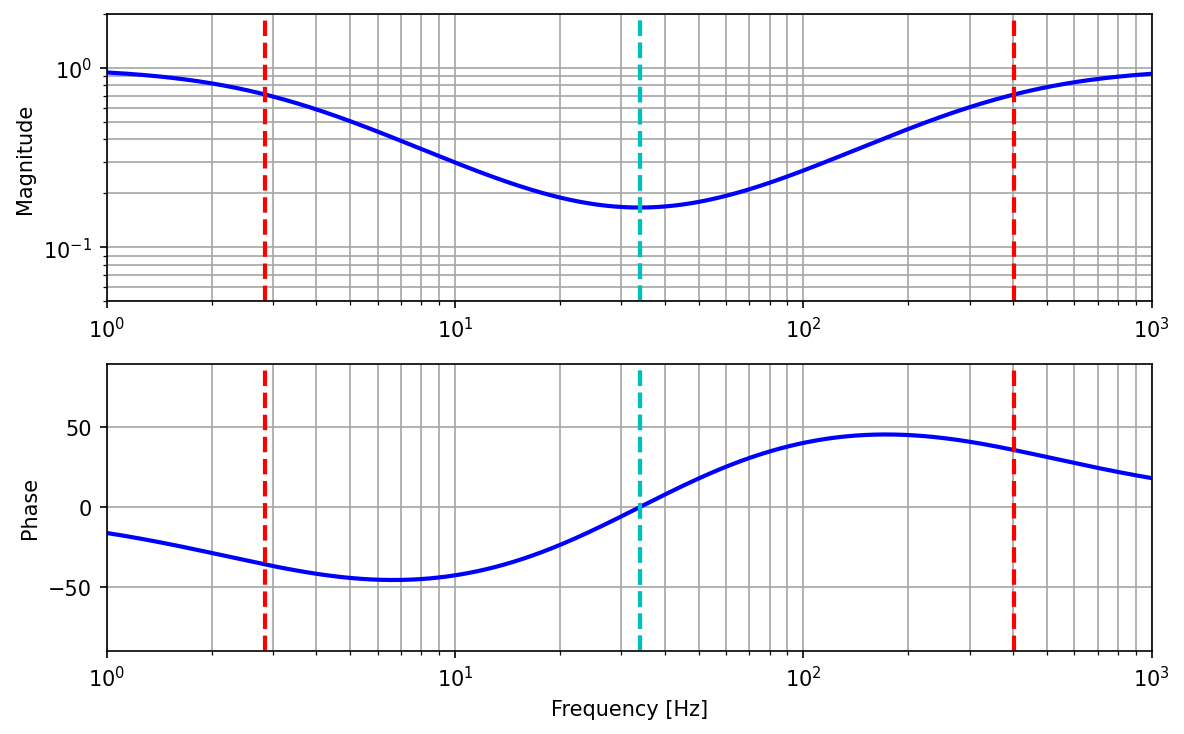

In [49]:
fv = logspace(0, 3, 1000)
Gf = G(complex(0,1)*fv*2*np.pi)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-')
ax[1].semilogx(fv,np.angle(Gf)*r2d,color='b',ls='-')
ax[0].set_ylim([.05,2])
ax[1].set_ylim([-90,90])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
for ii in range(2):
    [ax[ii].axvline(x=np.abs(p/2/np.pi),c='r',ls='--') for p in G.poles()]
    [ax[ii].axvline(x=np.abs(z/2/np.pi),c='c',ls='--') for z in G.zeros()]
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
savefig('figs/Analog_Lag_Lead.pdf',dpi=600)

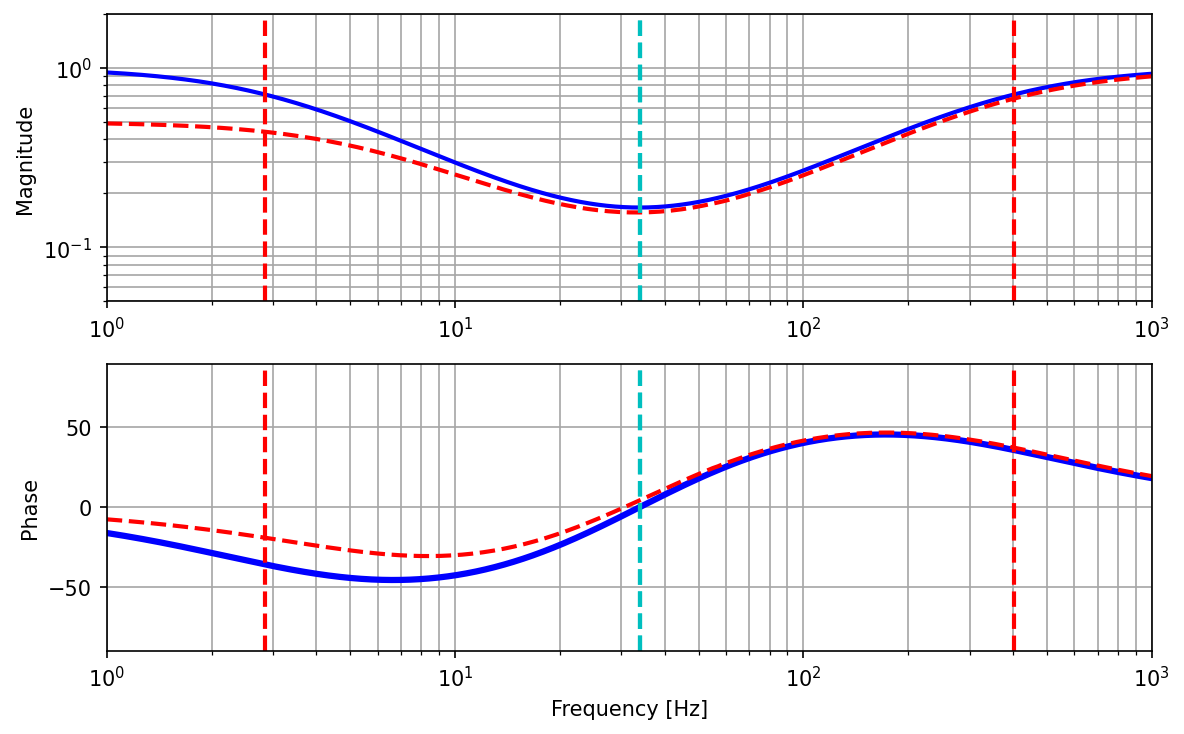

In [50]:
data = np.genfromtxt('data/Analog_Lag_lead2.csv', delimiter=",")

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-',label='model')
ax[0].loglog(data[:,0],data[:,1],color='r',ls='--',label='data')
ax[1].semilogx(fv,np.angle(Gf)*r2d,color='b',ls='-',lw=3,label='model')
ax[1].semilogx(data[:,0],data[:,2],color='r',ls='--',label='data')
ax[0].set_ylim([.05,2])
ax[1].set_ylim([-90,90])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
for ii in range(2):
    [ax[ii].axvline(x=np.abs(p/2/np.pi),c='r',ls='--') for p in G.poles()]
    [ax[ii].axvline(x=np.abs(z/2/np.pi),c='c',ls='--') for z in G.zeros()]
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
savefig('figs/Analog_Lag_Lead_with_data.pdf',dpi=600)

## Active Lead

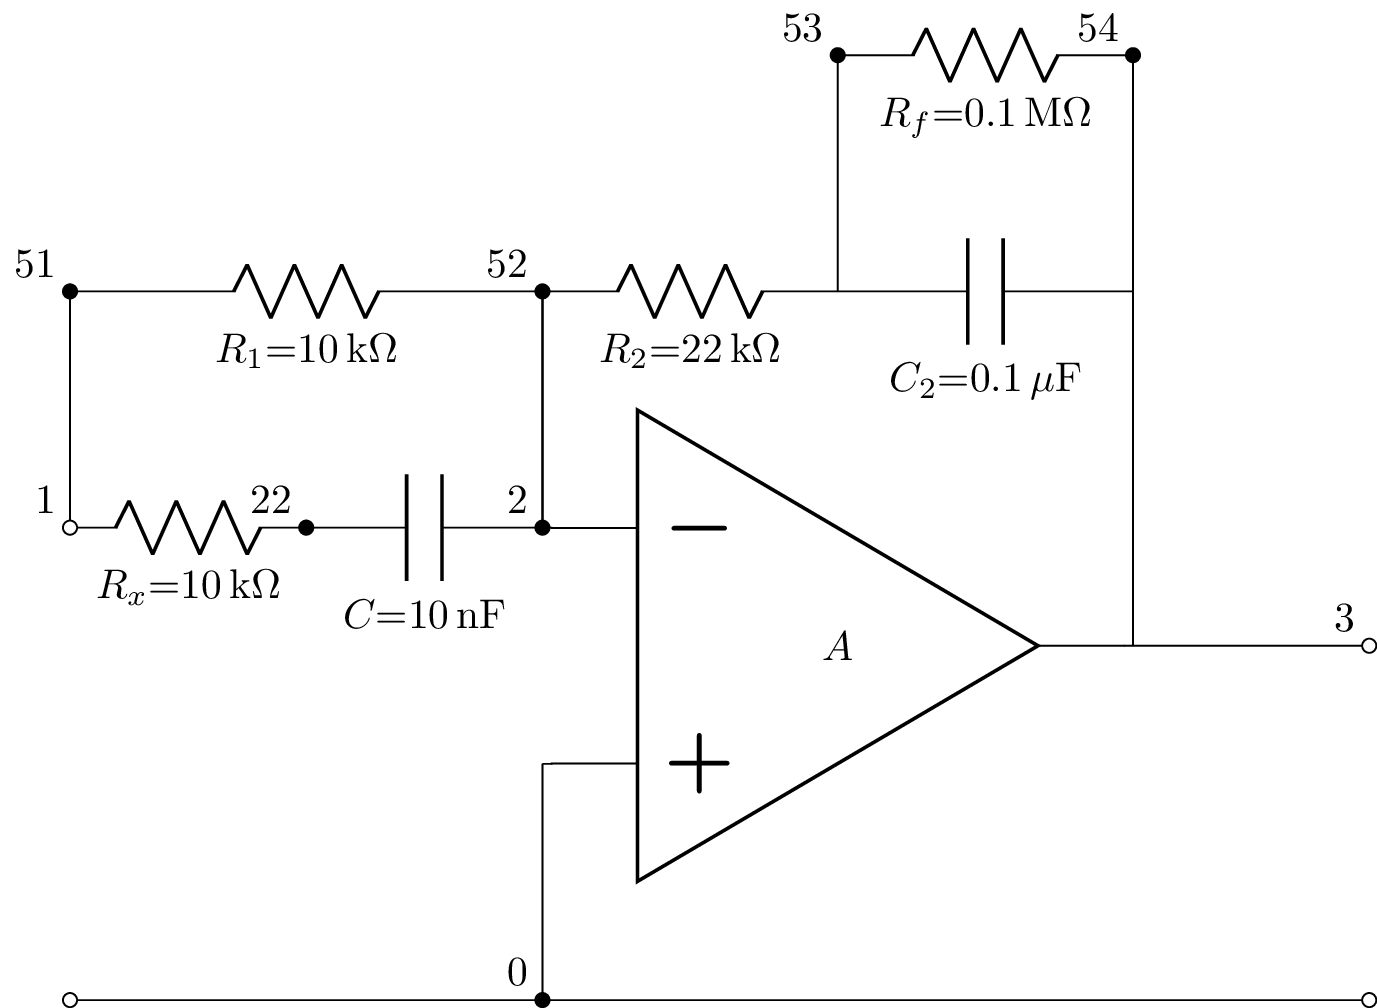

In [51]:
CC = 0.1e-6 # capacitor value
RR = 10e3 # res value

cct_test1 = Circuit("""
P1 1 0_1; down
Rx 1 22; right
C 22 2; right
W 1 51; up 
W 2 52; up 
R1 51 52; right
R2 2_1 4_1; right
C2 4_1 3_1; right
W 4_1 53; up 
W 3_1 54; up 
Rf 53 54; right
E1 3_2 0_3 opamp 2_0 2 A; mirror
W 0_1 0; right
W 2_0 0; down
W 3_2 3; right
W 0 0_3; right
P2 3 0_3; down
W 2_1 2; down
W 3_1 3_2; down
""")
cct9 = cct_test1.subs({'Rx': RR, 'R1': RR, 'R2': 2.2*RR, 'Rf': 10*RR, 'C':CC/10, 'C1':CC, 'C2':CC})
cct9.draw()


In [73]:
Hl = cct9.P1.transfer('P2').limit('A', oo)
Num,Den = N(Hl).as_N_D()
NN = [Num.coeffs()[x].fval for x in range(len(Num.coeffs()))]
DD = [Den.coeffs()[x].fval for x in range(len(Den.coeffs()))]

G = tf(np.real(NN),np.real(DD))
print("Poles = "+', '.join('{:6.2f}'.format(x) for x in G.poles()/2/np.pi))
print("Zeros = "+', '.join('{:6.2f}'.format(x) for x in G.zeros()/2/np.pi))
G

Poles = -1591.55+0.00j, -15.92+0.00j
Zeros = -795.77+0.00j, -88.26+0.00j


TransferFunction(array([  -0.000,   -0.024,  -12.200]), array([   0.000,    0.010,    1.000]))

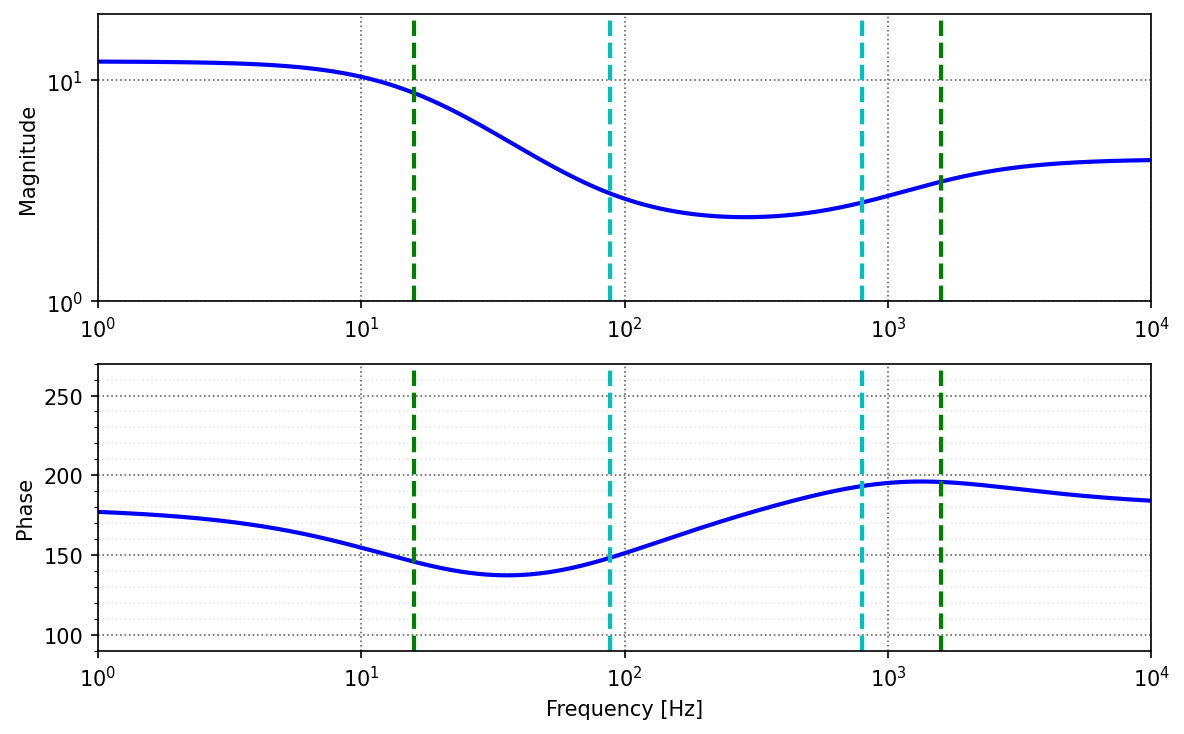

In [82]:
fv = logspace(0, 4, 1000)
wv = fv*2*np.pi
Gf = G(complex(0,1)*wv)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-')
ax[1].semilogx(fv,np.unwrap(np.angle(Gf))*r2d,color='b',ls='-')
ax[0].set_ylim([1,20])
ax[1].set_ylim([90,270])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
for ii in range(2):
    [ax[ii].axvline(x=np.abs(p/2/np.pi),c='g',ls='--') for p in np.abs(G.poles())]
    [ax[ii].axvline(x=np.abs(z/2/np.pi),c='c',ls='--') for z in np.abs(G.zeros())]
nicegrid(ax)
savefig('figs/Active_Lead.pdf',dpi=600)


# Resonant Dynamics

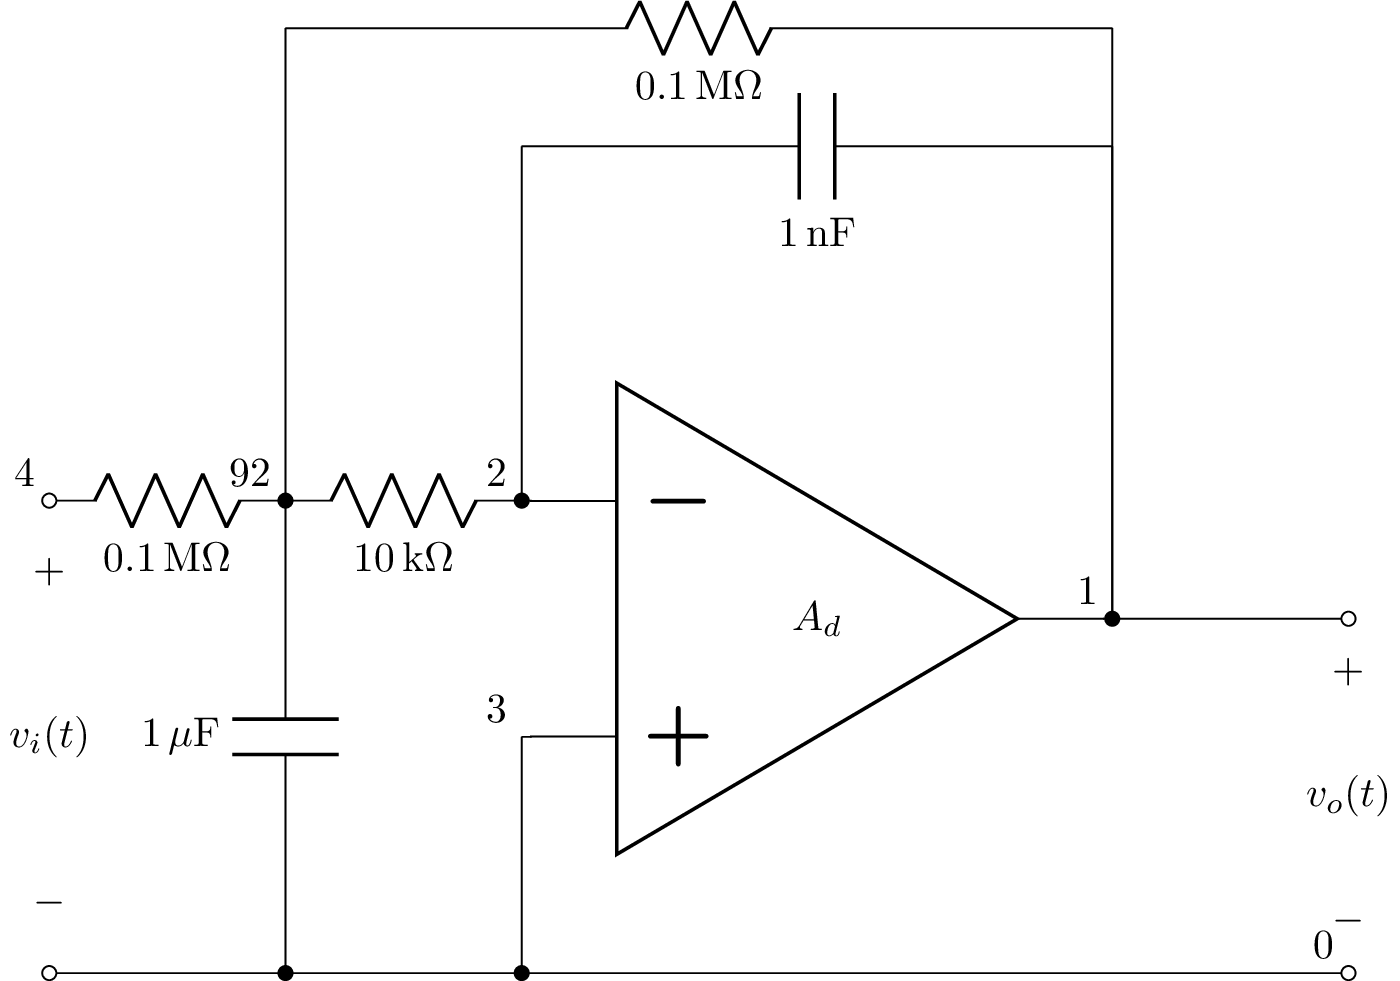

In [53]:
a = Circuit("""
E 1 0 opamp 3 2 Ad; right, flipud
R1 4 92; right
R2 92 2; right
W 92 2_2; up=2
R3 2_2 1_1; right
W 1_1 1; down
#
W 2 2_8; up=1.5
C2 2_8 3_8;right
W 3_8 1;down
#
Pi 4 0_1; down, v^=v_i(t)
W 3 0_2; down
W 1 1_2; right
Po 1_2 0; down, v^=v_o(t)
W 0_1 0_92; right
W 0_92 0_2; right
W 0_2 0; right
C1 92 0_92; down
; draw_nodes=connections, label_ids=none, label_nodes=primary
""")
cct10 = a.subs({'R1': 100e3, 'R2': 10e3, 'R3': 1e5, 'C1': 1*1e-6, 'C2': 1e-9})
cct10.draw()

In [54]:
from sympy import sqrt, simplify, N
RR = a.Pi.transfer('Po').limit('Ad', oo)
hh = RR.as_N_D()[1]
hhh = hh.coeffs()
wn = (hhh[2]/hhh[0])**(0.5)
print(wn)
zeta = ((hhh[1]/hhh[0])/2/wn).limit('R1', oo)
zeta

1/(sqrt(C1)*sqrt(C2)*sqrt(R2)*sqrt(R3))


        C₂⋅R₂ + C₂⋅R₃        
─────────────────────────────
    ____   ____   ____   ____
2⋅╲╱ C₁ ⋅╲╱ C₂ ⋅╲╱ R₂ ⋅╲╱ R₃ 

In [55]:
Hl = cct10.Pi.transfer('Po').limit('Ad', oo)
Num,Den = N(Hl).as_N_D()
NN = [Num.coeffs()[x].fval for x in range(len(Num.coeffs()))]
DD = [Den.coeffs()[x].fval for x in range(len(Den.coeffs()))]

G = tf(np.real(NN),np.real(DD))
print("Poles = "+', '.join('{:6.2f}'.format(x) for x in G.poles()))
print("Zeros = "+', '.join('{:6.2f}'.format(x) for x in G.zeros()))

G

Poles = -60.00+998.20j, -60.00-998.20j
Zeros = 


TransferFunction(array([  -1.000]), array([   0.000,    0.000,    1.000]))

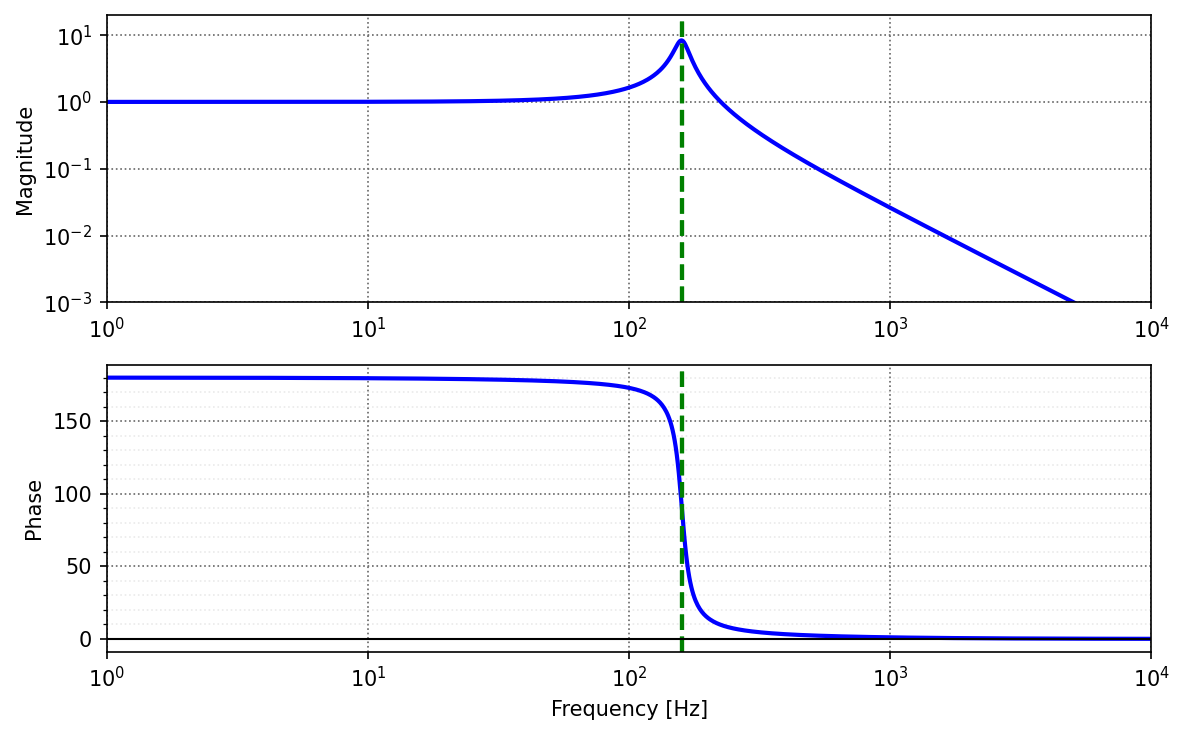

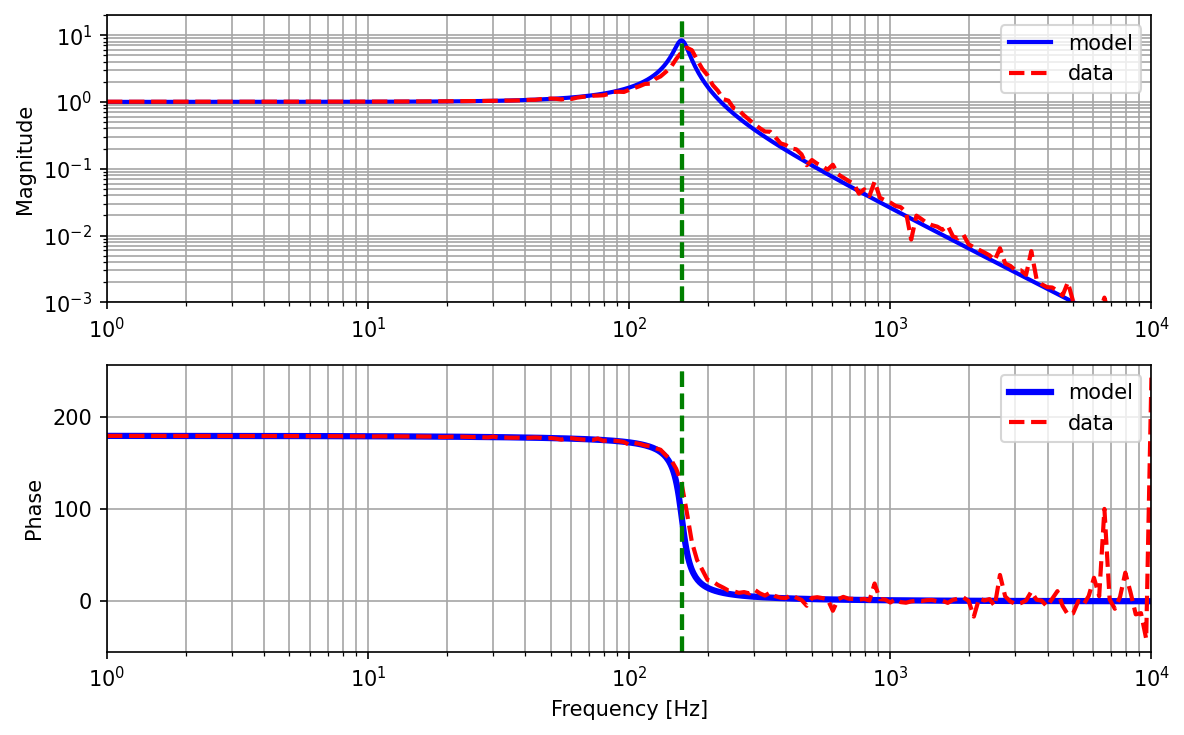

In [56]:
fv = logspace(0, 4, 1000)
wv = fv*2*np.pi
Gf = G(complex(0,1)*wv)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-')
ax[1].semilogx(fv,np.angle(Gf)*r2d,color='b',ls='-')
ax[0].set_ylim([.001,20])
#ax[1].set_ylim([90,270])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
for ii in range(2):
    [ax[ii].axvline(x=np.abs(p/2/np.pi),c='g',ls='--') for p in np.abs(G.poles())]
    [ax[ii].axvline(x=np.abs(z/2/np.pi),c='c',ls='--') for z in np.abs(G.zeros())]
nicegrid(ax)
savefig('figs/Active_resonant.pdf',dpi=600)

data = np.genfromtxt('data/Active_Resonant.csv', delimiter=",")

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150)
ax[0].loglog(fv,np.abs(Gf),color='b',ls='-',label='model')
ax[0].loglog(data[:,0],10**(data[:,1]/20),color='r',ls='--',label='data')
ax[1].semilogx(fv,np.angle(Gf)*r2d,color='b',ls='-',lw=3,label='model')
ax[1].semilogx(data[:,0],data[:,2],color='r',ls='--',label='data')
ax[0].set_ylim([.001,20])
#ax[1].set_ylim([135,225])
ax[0].set_ylabel("Magnitude")
ax[1].set_ylabel("Phase")
ax[1].set_xlabel("Frequency [Hz]")
for ii in range(2):
    [ax[ii].axvline(x=np.abs(p/2/np.pi),c='g',ls='--') for p in np.abs(G.poles())]
    [ax[ii].axvline(x=np.abs(z/2/np.pi),c='c',ls='--') for z in np.abs(G.zeros())]
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].legend()
ax[1].legend()
savefig('figs/Active_resonant_with_data.pdf',dpi=600)


In [57]:
a.Pi.transfer('Po').limit('Ad', oo)

                            -R₃                              
─────────────────────────────────────────────────────────────
                2                                            
C₁⋅C₂⋅R₁⋅R₂⋅R₃⋅s  + C₂⋅R₁⋅R₂⋅s + C₂⋅R₁⋅R₃⋅s + C₂⋅R₂⋅R₃⋅s + R₁

In [58]:
wd = G.poles()[0].imag
wn = np.abs(G.poles()[0])
zeta = -G.poles()[0].real/wn
print("zeta,wn,wd "+', '.join('{:>8.3f}'.format(i) for i in [zeta, wn/2/np.pi, wd, wn*np.sqrt(1-zeta**2)]))

zeta,wn,wd    0.060,  159.155,  998.198,  998.198


In [59]:
G.poles()[0].real/wn

In [60]:
bojack_resistors = np.array([
    1.0, 2.2, 3.3, 10, 22, 47, 68, 100, 120, 150, 220, 330, 470, 560, 680, 1_000, 2_000, 2_200, 4_700, 5_600, 10_000, 22_000, 47_000, 100_000, 1_000_000])

In [61]:
bojack_capacitors = np.array([
    10e-12, 20e-12, 30e-12, 47e-12, 56e-12, 68e-12, 100e-12, 220e-12, 330e-12, 680e-12,  # pF range
    1e-9, 4.7e-9, 10e-9, 47e-9, 100e-9,  150e-9, 220e-9, 330e-9, 470e-9, 680e-9, # nF range
    0.1e-6, 0.15e-6, 0.22e-6, 0.33e-6, 0.47e-6, 0.68e-6, 1.0e-6, 2.2e-6, 4.7e-6, 10e-6,  # Larger μF range
])

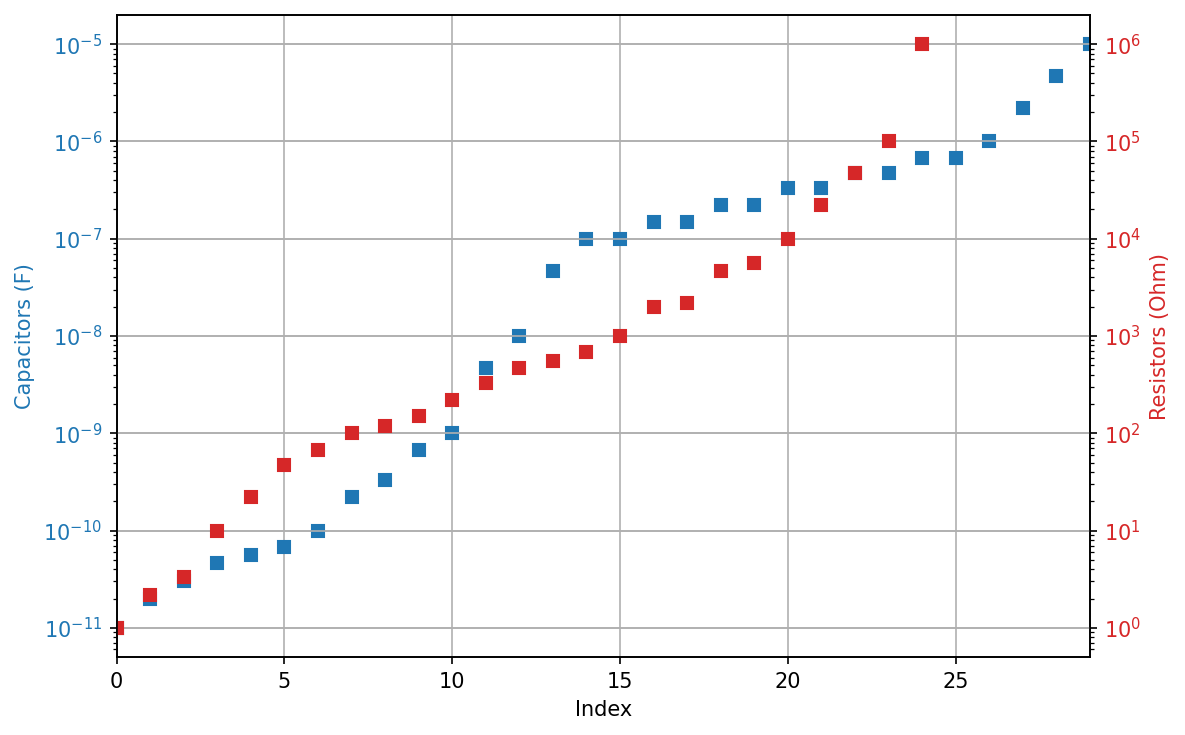

In [62]:
fig, ax1 = plt.subplots(1, figsize=(8, 5), dpi=150)

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Capacitors (F)', color=color)
ax1.semilogy(np.sort(bojack_capacitors), 's', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Resistors (Ohm)', color=color)
ax2.semilogy(np.sort(bojack_resistors), 's', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


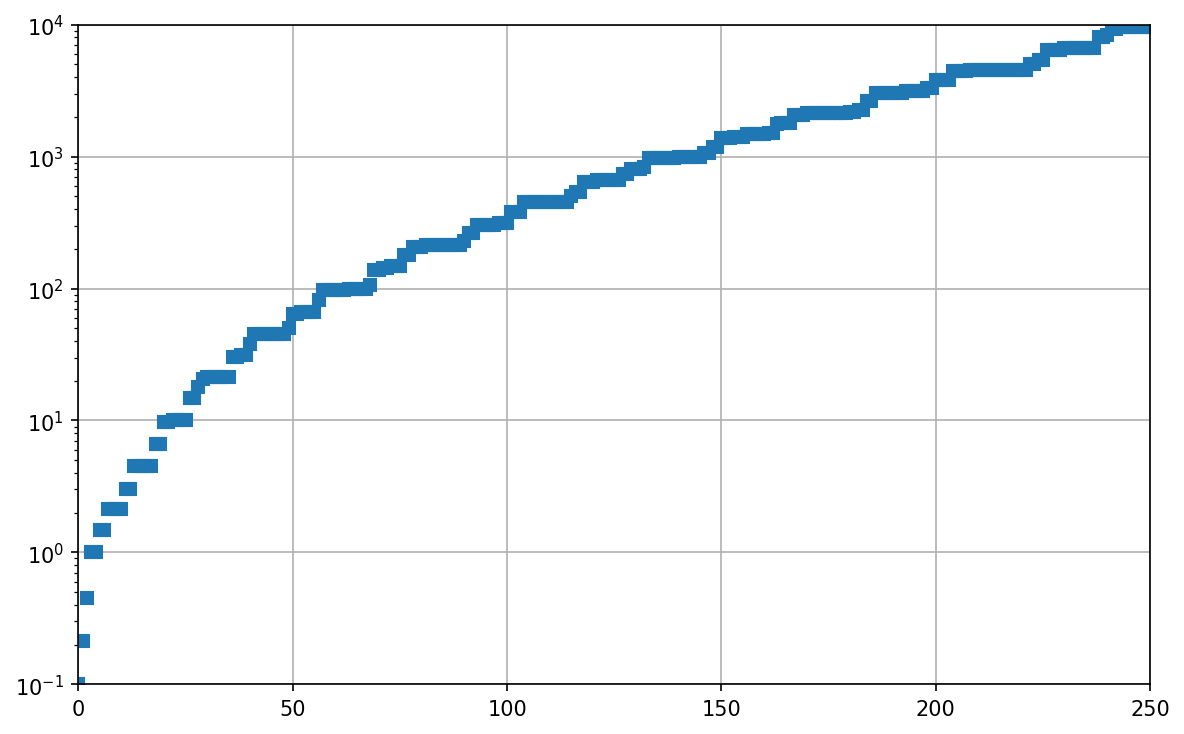

In [63]:
tau = []
for r in bojack_resistors:
    for c in bojack_capacitors:
        tau.append(1/r/c)

fig, ax1 = plt.subplots(1, figsize=(8, 5), dpi=150)
plt.semilogy(np.sort(tau),'s')
plt.ylim(.1,1e4)
plt.xlim(0,250)

In [64]:
CC1 = 1e-6
CC2 = 1e-9
R1 = 100e3
R2 = 10e3
R3 = 100e3
print('   alpha     beta      zeta      wn')
for alp in [0.1,1,10]:
    C1 = alp*CC1
    for beta in [0.1,1,10]:
        C2 = beta*CC2
        wn = np.sqrt(1/(C1*C2*R2*R3))
        zeta = (R1*R2 + R2*R3 + R1*R3)/(C1*R1*R2*R3)/2./wn
        print(""+', '.join('{:>8.3f}'.format(i) for i in [alp,beta,zeta,wn/2/np.pi]))

   alpha     beta      zeta      wn
   0.100,    0.100,    0.060, 1591.549
   0.100,    1.000,    0.190,  503.292
   0.100,   10.000,    0.600,  159.155
   1.000,    0.100,    0.019,  503.292
   1.000,    1.000,    0.060,  159.155
   1.000,   10.000,    0.190,   50.329
  10.000,    0.100,    0.006,  159.155
  10.000,    1.000,    0.019,   50.329
  10.000,   10.000,    0.060,   15.915


In [86]:
import numpy as np

# Define the target zeta and wn
target_zeta = 0.03
target_wn = 100.0

# Initialize variables to store the best match
best_match = None
best_error = float('inf')

# Iterate over all combinations of resistors and capacitors
for R1 in bojack_resistors:
    for R2 in bojack_resistors:
        for R3 in bojack_resistors:
            for C1 in bojack_capacitors:
                for C2 in bojack_capacitors:
                    # Calculate wn and zeta for the current combination
                    wn = np.sqrt(1 / (C1 * C2 * R2 * R3))
                    zeta = (R1 * R2 + R2 * R3 + R1 * R3) / (C1 * R1 * R2 * R3) / (2 * wn)
                    
                    # Calculate the error
                    error = np.abs(zeta - target_zeta) + np.abs(wn - target_wn)
                    
                    # Update the best match if the current error is smaller
                    if error < best_error:
                        best_error = error
                        best_match = (R1, R2, R3, C1, C2, zeta, wn)

# Print the best match
print(f"Best match: R1={best_match[0]}, R2={best_match[1]}, R3={best_match[2]}, C1={best_match[3]}, C2={best_match[4]}")
print(f"zeta={best_match[5]:4.2f}, wn={best_match[6]:4.2f}, best_error={best_error:.4f}")

Best match: R1=22000.0, R2=100000.0, R3=1000000.0, C1=1e-05, C2=1e-10
zeta=0.03, wn=100.00, best_error=0.0018


# Two resistor

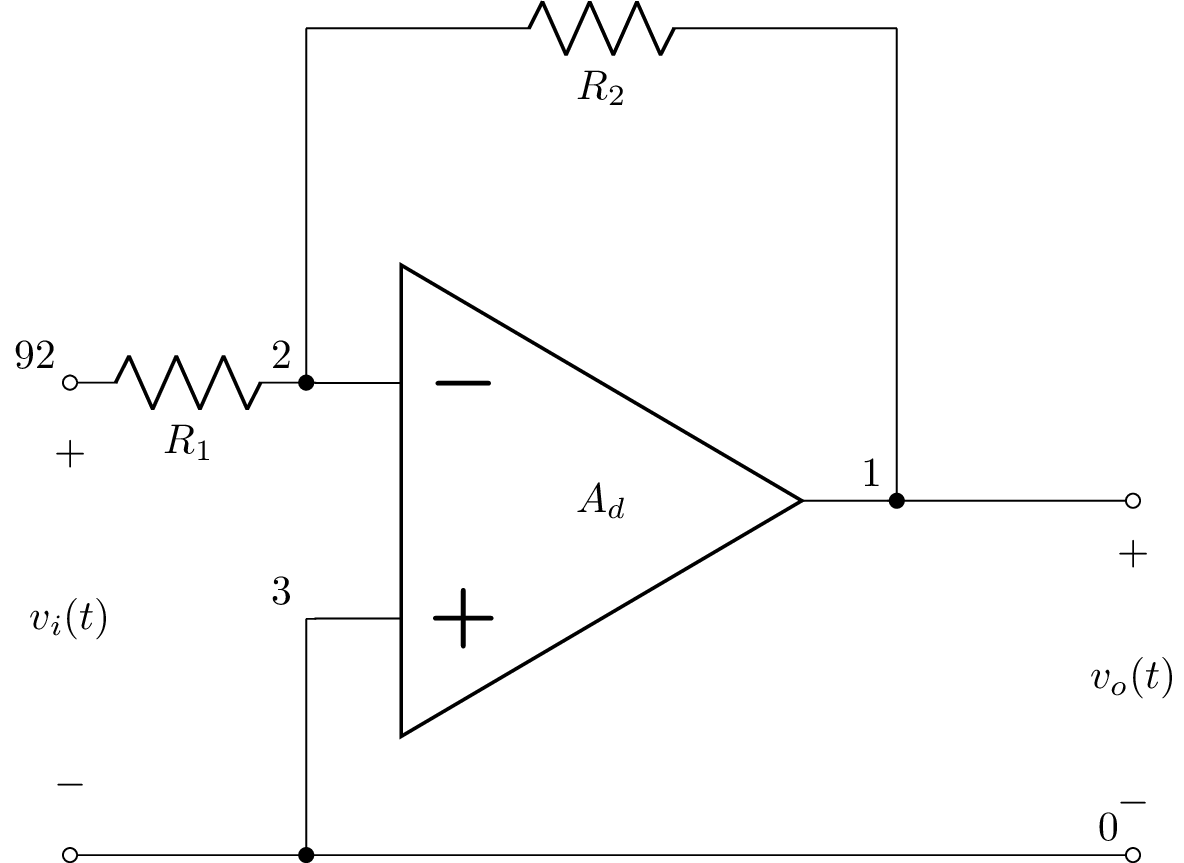

In [66]:
aa = Circuit("""
E 1 0 opamp 3 2 Ad; right, flipud
#
W 2 2_8; up=1.5
R1 92 2 R1; right
R2 2_8 3_8 R2;right
W 3_8 1;down
#
Pi 92 0_1; down, v^=v_i(t)
W 3 0_2; down
#
W 1 1_2; right
Po 1_2 0; down, v^=v_o(t)
W 0_1 0_2; right
W 0_2 0; right
#
; draw_nodes=connections, label_ids=none, label_nodes=primary
""")
#cct10 = aa.subs({'R1': 100e3, 'R2': 10e3, 'R3': 1e5, 'C1': 1*1e-6, 'C2': 1e-9})
aa.draw()

In [67]:
aa.Pi.transfer('Po')

    -A_d⋅R₂       
────────────────⋅1
A_d⋅R₁ + R₁ + R₂  

In [68]:
aa.Pi.transfer('Po').limit('Ad', oo)

-R₂ 
────
 R₁ 

## What designs are possible

In [69]:
bojack_resistors = np.array([
    1.0, 2.2, 3.3, 10, 22, 47, 68, 100, 120, 150, 220, 330, 470, 560, 680, 1_000, 2_000, 2_200, 4_700, 5_600, 10_000, 22_000, 47_000, 100_000, 1_000_000])

In [70]:
bojack_capacitors = np.array([
    10e-12, 20e-12, 30e-12, 47e-12, 56e-12, 68e-12, 100e-12, 220e-12, 330e-12, 680e-12,  # pF range
    1e-9, 4.7e-9, 10e-9, 47e-9, 100e-9,  150e-9, 220e-9, 330e-9, 470e-9, 680e-9, # nF range
    0.1e-6, 0.15e-6, 0.22e-6, 0.33e-6, 0.47e-6, 0.68e-6, 1.0e-6, 2.2e-6, 4.7e-6, 10e-6,  # Larger μF range
])

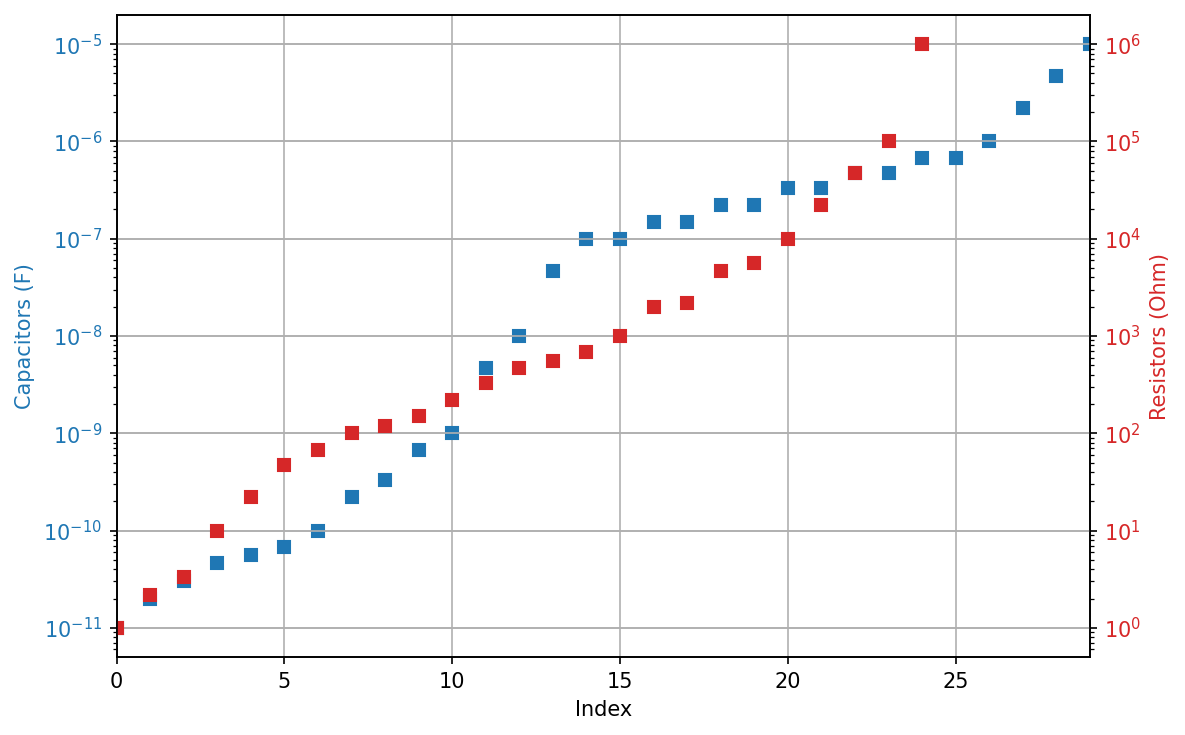

In [71]:
fig, ax1 = plt.subplots(1, figsize=(8, 5), dpi=150)

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Capacitors (F)', color=color)
ax1.semilogy(np.sort(bojack_capacitors), 's', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Resistors (Ohm)', color=color)
ax2.semilogy(np.sort(bojack_resistors), 's', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


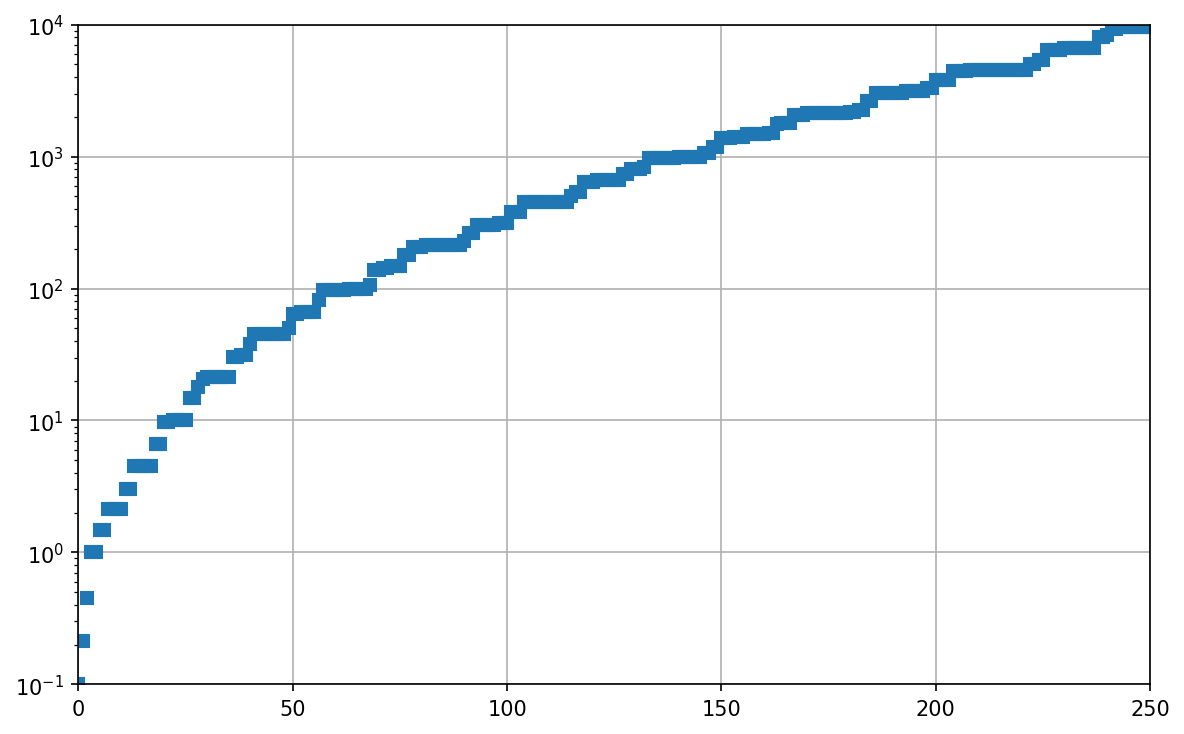

In [72]:
tau = []
for r in bojack_resistors:
    for c in bojack_capacitors:
        tau.append(1/r/c)

fig, ax1 = plt.subplots(1, figsize=(8, 5), dpi=150)
plt.semilogy(np.sort(tau),'s')
plt.ylim(.1,1e4)
plt.xlim(0,250)